# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : CamemBERT Recueil

---

# Environnement
---

In [1]:
cd ../..

/Volumes/Geek/Work/Patat


In [2]:
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

## Données

In [3]:
import patat.util.pd

filename = 'data/prod/230512-OIDS-Label.csv'

df_label = patat.util.pd.df_from_csvjson(['tags','paragraphs'],filename)

df_label['infox'].isna().sum()

df_label = df_label[df_label['infox'].notna()]

## GPU Check

In [9]:
import torch

torch_device='cpu'

if torch.backends.mps.is_available():
    torch_device='mps'
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
print(f'torch_device = {torch_device} ')

tensor([1.], device='mps:0')
torch_device = mps 


# Python modules

In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

from tabulate import tabulate
from tqdm import trange, tqdm
import random

# Tokenization

## Réduction Texte

In [45]:
def partial_texts(text,p_count):
    parags = text.split('\n')
    result='\n'.join(parags[:p_count])
    return result

nb_parags = 3

def cut_text(text):
    return partial_texts(text,nb_parags)

In [46]:
df_label['r_text']=df_label['text'].apply(cut_text)

In [83]:
labels = df_label['infox']
texts = df_label['r_text']

## Tokenisation naive

In [47]:
import re

In [48]:
token_re = r'[\w]\w+'
def naive_tokenizer(text):
    return re.findall(token_re,text)

## CamemBERT tokenizer

In [49]:
bert_tokenizer = AutoTokenizer.from_pretrained("camembert-base")

In [57]:
text = df_label.sample(1)['r_text'].iloc[0]

In [58]:
len(naive_tokenizer(text))

65

In [59]:
len(bert_tokenizer.tokenize(text))

112

In [64]:
df_label['bert_tokens']=df_label['r_text'].apply(bert_tokenizer.tokenize)

In [65]:
df_label['bert_tokens']

0      [▁L, ’, Arabie, ▁saoudite, ▁organise, ▁des, ▁c...
1      [▁«, ▁Quel, ▁art, ▁!, ▁», ▁:, ▁un, ▁étudiant, ...
2      [▁L, ’, Australie, ▁ne, ▁reconnaît, ▁plus, ▁Jé...
3      [▁Nantes, ▁:, ▁une, ▁mère, ▁musulmane, ▁meurt,...
4      [▁La, ▁France, ▁condamnée, ▁pour, ▁avoir, ▁pla...
                             ...                        
890    [▁Z, aki, r, ▁Na, ik, ,, ▁prédicateur, ▁indien...
891    [▁Une, ▁grande, ▁partie, ▁des, ▁électeurs, ▁de...
892    [▁C, ', est, ▁dans, ▁ma, ▁tête, ., ▁L, ’, acce...
893    [▁2015, -, 2019, ., ▁Des, ▁hôpitaux, ▁déjà, ▁s...
894    [▁Vidéo, ▁", Mi, s, sion, ▁flash, ", ▁sur, ▁le...
Name: bert_tokens, Length: 895, dtype: object

In [66]:
df_label['btokens_count'] = df_label['bert_tokens'].apply(len)

In [70]:
df = df_label[df_label['btokens_count']<512]

In [71]:
df.shape

(887, 47)

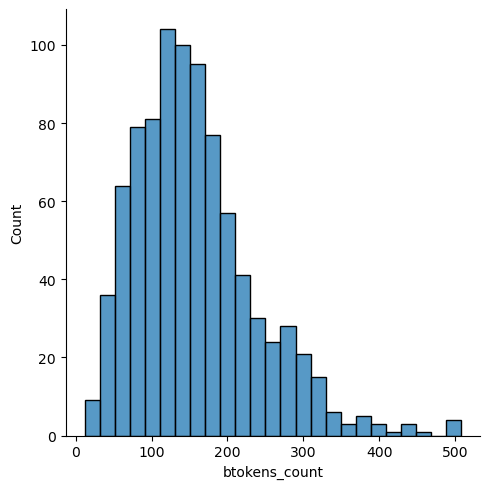

In [72]:
sns.displot(df,x='btokens_count')

In [74]:
text = df_label.sample(1)['r_text'].iloc[0]

In [77]:
table = np.array([bert_tokenizer.tokenize(text), 
                bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(text))]).T
print(tabulate(table,
         headers = ['Tokens', 'Token IDs'],
         tablefmt = 'fancy_grid'))

╒═════════════════╤═════════════╕
│ Tokens          │   Token IDs │
╞═════════════════╪═════════════╡
│ ▁Ils            │         436 │
├─────────────────┼─────────────┤
│ ▁veulent        │        1882 │
├─────────────────┼─────────────┤
│ ▁la             │          13 │
├─────────────────┼─────────────┤
│ ▁guerre         │         775 │
├─────────────────┼─────────────┤
│ ▁totale         │        2273 │
├─────────────────┼─────────────┤
│ ,               │           7 │
├─────────────────┼─────────────┤
│ ▁mais           │          65 │
├─────────────────┼─────────────┤
│ ▁à              │          15 │
├─────────────────┼─────────────┤
│ ▁la             │          13 │
├─────────────────┼─────────────┤
│ ▁façon          │         429 │
├─────────────────┼─────────────┤
│ ▁des            │          20 │
├─────────────────┼─────────────┤
│ ▁lâche          │        8045 │
├─────────────────┼─────────────┤
│ s               │          10 │
├─────────────────┼─────────────┤
│ ▁TR         

In [87]:
tokenizer = bert_tokenizer
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(texts)-1)
  table = np.array([tokenizer.tokenize(texts[index]), 
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(texts[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒═══════════════╤═════════════╕
│ Tokens        │   Token IDs │
╞═══════════════╪═════════════╡
│ ▁Anthony      │       16369 │
├───────────────┼─────────────┤
│ ▁Fau          │       10340 │
├───────────────┼─────────────┤
│ ci            │         244 │
├───────────────┼─────────────┤
│ ▁:            │          43 │
├───────────────┼─────────────┤
│ ▁d            │          18 │
├───────────────┼─────────────┤
│ '             │          11 │
├───────────────┼─────────────┤
│ une           │          70 │
├───────────────┼─────────────┤
│ ▁gestion      │         718 │
├───────────────┼─────────────┤
│ ▁de           │           8 │
├───────────────┼─────────────┤
│ ▁crise        │        1662 │
├───────────────┼─────────────┤
│ ▁controversé  │       19833 │
├───────────────┼─────────────┤
│ e             │          35 │
├───────────────┼─────────────┤
│ ▁à            │          15 │
├───────────────┼─────────────┤
│ ▁une          │          28 │
├───────────────┼─────────────┤
│ ▁démis

# Sentence Encoding / Embeding

In [88]:

token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in texts:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids']) 
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/homebrew/Caskroom/miniforge/base/envs/gpu39/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [89]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(texts) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table, 
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════════╤═════════════╤══════════════════╕
│ Tokens       │   Token IDs │   Attention Mask │
╞══════════════╪═════════════╪══════════════════╡
│ <s>          │           5 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ▁Etats       │        1490 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ -            │          26 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ Unis         │        1047 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ :            │          92 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ▁la          │          13 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ▁Floride     │       19461 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ▁fait        │          82 │                1 │
├──────────────┼─────────────┼──────────────────┤
│ ▁du          │          25 │                1 │


# Train / Test Split

In [90]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx], 
                          attention_masks[train_idx], 
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx], 
                        attention_masks[val_idx], 
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

# Metrics

In [91]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

# Training

In [93]:
from transformers import AutoModelForSequenceClassification


# Load the BertForSequenceClassification model
model = AutoModelForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels = 1,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(), 
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Run on GPU
#model.cuda()
#model.to('cpu')
model.to(torch_device)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [99]:
#%%time
#device=torch.device('cpu')
device=torch.device(torch_device)
#device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 2
for _ in tqdm(epochs, desc = 'Epoch'):
    
    # ========== Training ==========
    # Set model to training mode
    model.train()
    
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader)):
        
        batch = tuple(t.to(torch.float32).to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids.to(torch.int), 
                             token_type_ids = None, 
                             attention_mask = b_input_mask, 
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables 
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(torch.float32).to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids.to(torch.int), 
                              token_type_ids = None, 
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch: 0it [00:00, ?it/s]


TypeError: 'int' object is not iterable

# Make Predictions

In [95]:
new_sentence = 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.'

In [96]:
new_sentence = 'Please update your account data at https://dsfsdsq.ru/sd'

In [98]:
# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Infox' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'Non Infox'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  Please update your account data at https://dsfsdsq.ru/sd
Predicted Class:  Non Infox


# Data

In [ ]:
#!wget 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'

In [ ]:
#!unzip -o smsspamcollection.zip

In [ ]:
cd ../..

In [ ]:
import patat.util.pd

In [ ]:
filename = 'data/prod/230512-OIDS-Label.csv'
df_label = patat.util.pd.df_from_csvjson(['tags','paragraphs'],filename)

In [ ]:
df_label = df_label.sample(frac=1)

In [ ]:
texts = df_label['title'].values
labels = df_label['infox'].values

In [ ]:
texts[:10]

In [ ]:
labels[:10]

# Install

In [ ]:
!conda install transformers -y

In [ ]:
!conda install scikit-learn -y

In [ ]:
!conda install tabulate -y